In [2263]:
import sys

import pandas as pd
from keras.callbacks import ModelCheckpoint
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold, cross_val_score, HalvingGridSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from time import perf_counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

import numpy as np

import keras_tuner
import tensorflow as tf
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [2264]:
# plotly settings
px.defaults.template = 'plotly_dark'
px.defaults.width = 800
px.defaults.height = 450

In [2265]:
# to have the comp metric
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [2266]:
# helper for plotting
def plotly_scatter(df, f1, f2):
    fig = px.scatter(x=df[f1], y=df[f2]).update_layout(
    xaxis_title=f1, yaxis_title=f2, title=f'{f2} vs {f1}')
    fig.show()

In [2267]:
# load the data
train = pd.read_parquet(f'./data/train.parquet')
test = pd.read_parquet(f'./data/test.parquet')

In [2268]:
# inspect
train.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [2269]:
# check dtypes.. we can see a lot of non numeric features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [2270]:
# drop Id col but save test_IDs for submission
train.drop("Id", axis = 1, inplace = True)
test_IDs = test["Id"]
test.drop("Id", axis = 1, inplace = True)

## EDA and Transforms

<AxesSubplot:>

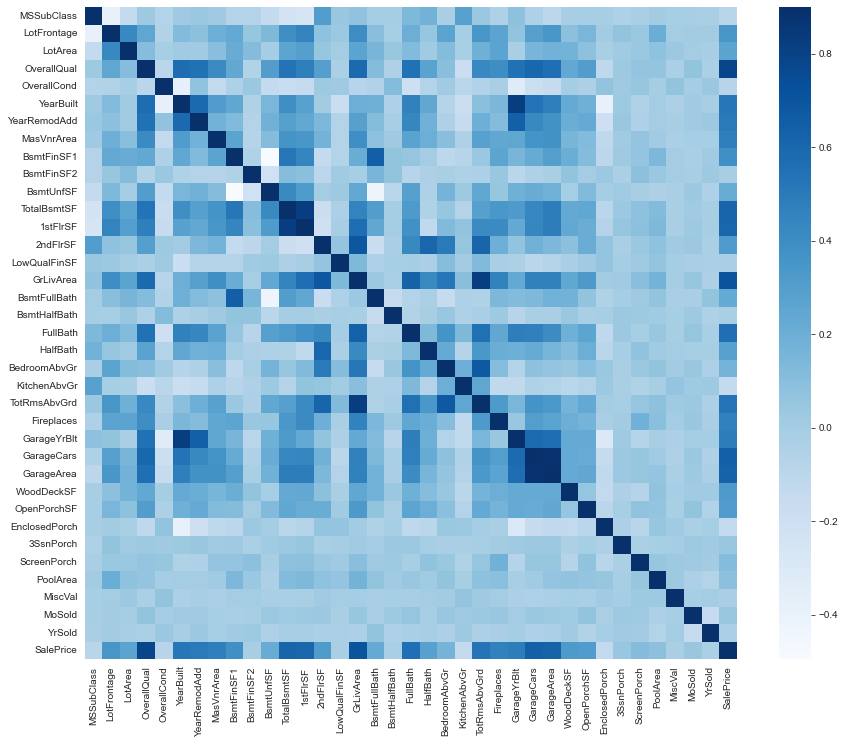

In [2271]:
# check linear corr
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [2272]:
# check the highest corrs
corrs = train.corr()['SalePrice'].sort_values(ascending=False)[1:21]
px.bar(corrs).update_layout(
    xaxis_title='feature', yaxis_title='correlation', title='Correlations With Playtime')

In [2273]:
# check the outliers for the most highly correlated features
for c in corrs.index[:5]:
    plotly_scatter(train, c, 'SalePrice')

In [2274]:
# filter outliers based on the plots
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF']>4500)].index, inplace=True)
train.drop(train[(train['GarageArea']>1220)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [2275]:
# check target distribution
fig = ff.create_distplot([train["SalePrice"]], group_labels=['distplot'], bin_size=10000)
fig.update_layout(title_text='Curve and Rug Plot')
fig.show()

We can see that the SalePrice targets have a slight positive skew. We can correct this with a log transform.

In [2276]:
# transform targets
train["SalePrice"] = np.log1p(train["SalePrice"])

In [2277]:
fig = ff.create_distplot([train["SalePrice"]], group_labels=['distplot'], bin_size=.05)
fig.update_layout(title_text='Curve and Rug Plot')
fig.show()

In [2278]:
# separate the targets
y_train = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# combine train and test features, before cleaning
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2913, 79)

In [2279]:
# convert non cardinal numerical features into strings
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [2280]:
# the data description states that NA refers to typical ('Typ') values
all_features['Functional'] = all_features['Functional'].fillna('Typ')
all_features['Electrical'] = all_features['Electrical'].fillna("SBrkr")
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")

# the data description stats that NA refers to "no pool
all_features["PoolQC"] = all_features["PoolQC"].fillna("None")

# description says nan means no alley access
all_features["Alley"] = all_features["Alley"].fillna("None")

# replace with 0
for col in ('GarageArea', 'GarageCars'):
    all_features[col] = all_features[col].fillna(0)

# nans for these categorical basement features, means there's no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_features[col] = all_features[col].fillna('None')

# fill with the median of the neighborhood
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [2281]:
# fill the rest, which we can't interpret with None and 0
objects = []
for i in all_features.columns:
    if all_features[i].dtype == object:
        objects.append(i)
all_features.update(all_features[objects].fillna('None'))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
all_features.update(all_features[numeric].fillna(0))

In [2282]:
all_features.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,...,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,69.403021,10113.405424,6.088225,5.566083,1971.297288,1984.251287,100.913835,438.686577,49.667353,560.149331,...,1870.115345,1.763817,471.343289,93.530381,47.260213,23.145898,2.607621,16.095434,2.091658,50.738414
std,21.193771,7758.911341,1.404996,1.113345,30.290390,20.890446,178.092327,443.958903,169.338330,438.974982,...,450.114935,0.760798,213.120051,126.410731,67.132175,64.301832,25.213828,56.237482,34.585013,567.904167
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7472.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,...,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,9450.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.000000,...,1977.000000,2.000000,479.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11526.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,732.000000,0.000000,803.000000,...,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.000000,...,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000


In [2283]:
# drop features with very low standard deviation -> they contain very little information
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC'], axis=1)

In [2284]:
# add some extra features
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [2285]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913 entries, 0 to 2912
Data columns (total 94 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          2913 non-null   object 
 1   MSZoning            2913 non-null   object 
 2   LotFrontage         2913 non-null   float64
 3   LotArea             2913 non-null   int64  
 4   Alley               2913 non-null   object 
 5   LotShape            2913 non-null   object 
 6   LandContour         2913 non-null   object 
 7   LotConfig           2913 non-null   object 
 8   LandSlope           2913 non-null   object 
 9   Neighborhood        2913 non-null   object 
 10  Condition1          2913 non-null   object 
 11  Condition2          2913 non-null   object 
 12  BldgType            2913 non-null   object 
 13  HouseStyle          2913 non-null   object 
 14  OverallQual         2913 non-null   int64  
 15  OverallCond         2913 non-null   int64  
 16  YearBu

In [2286]:
# descriptors for ordinal features: we can reduce the feature count a bit if we don't one-hot encode every categorical feature
desc = {
    'Alley':{
        'None':0,
        'Grvl':1,
        'Pave':2
    },
    'Utilities':{
        'ELO': 0,
        'NoSeWa': 1,
        'NoSewr': 2,
        'AllPub': 3

    },
    'ExterQual':{
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd':3,
        'Ex':4
    },
    'ExterCond': {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd':3,
        'Ex':4
    },
    'KitchenQual': {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd':3,
        'Ex':4
    }
        }

In [2287]:
# convert the above-mentioned features
for col in all_features.columns:
    if col in desc.keys():
        all_features[col] = all_features[col].map(desc[col])

In [2288]:
# onehot encode the rest
all_features = pd.get_dummies(all_features).reset_index(drop=True)

In [2289]:
all_features.describe()

,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,...,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,69.403021,10113.405424,0.094748,6.088225,5.566083,1971.297288,1984.251287,100.913835,2.395812,2.085479,...,0.081016,0.000343,0.002403,0.866117,0.065225,0.004119,0.008239,0.015791,0.823550,0.083076
std,21.193771,7758.911341,0.373325,1.404996,1.113345,30.290390,20.890446,178.092327,0.577934,0.372342,...,0.272907,0.018528,0.048970,0.340585,0.246965,0.064062,0.090409,0.124689,0.381268,0.276044
min,21.000000,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7472.000000,0.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,70.000000,9450.000000,0.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,80.000000,11526.000000,0.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,313.000000,215245.000000,2.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2290]:
all_features

,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,0,7,5,2003,2003,196.0,3,2,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,0,6,8,1976,1976,0.0,2,2,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,0,7,5,2001,2002,162.0,3,2,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,0,7,5,1915,1970,0.0,2,2,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,0,8,5,2000,2000,350.0,3,2,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,21.0,1936,0,4,7,1970,1970,0.0,2,2,...,0,0,0,1,0,0,0,0,1,0
2909,21.0,1894,0,4,5,1970,1970,0.0,2,2,...,0,0,0,1,1,0,0,0,0,0
2910,160.0,20000,0,5,7,1960,1996,0.0,2,2,...,0,0,0,1,1,0,0,0,0,0
2911,62.0,10441,0,5,5,1992,1992,0.0,2,2,...,0,0,0,1,0,0,0,0,1,0


In [2291]:
X_train = all_features.iloc[:len(y_train), :]
X_test = all_features.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape

((1454, 333), (1454,), (1459, 333))

## Decision Tree
We train a single regression tree and we use grid search with 10 fold cross validation for hyperparameter tuning.

In [2292]:
# # set the parameter grid
# parameters={
#             "max_features": list(np.arange(100, 320, 2)) + [len(all_features.columns)],
#             "max_leaf_nodes": list(np.arange(50, 100, 2))
#             }
# # get an estimator object
# estimator = DecisionTreeRegressor()
#
# # run optimizer
# t_start = perf_counter()
# sh_dfl = GridSearchCV(estimator, parameters, cv=10, verbose=1).fit(X_train, y_train)
# t_stop = perf_counter()
#
# # reuslts
# print(f'Took {(t_stop-t_start)/60:.2f} mins to optimize\nBest params:')
# [print(f'{k}: {v}') for k, v in sh_dfl.best_params_.items()]

In [2293]:
# Example output. I ran this a few times with slightly different settings.
# Fitting 10 folds for each of 2775 candidates, totalling 27750 fits
# Took 13.74 mins to optimize
# Best params:
# max_features: 236
# max_leaf_nodes: 54

In [2294]:
# dt = DecisionTreeRegressor(**sh_dfl.best_params_)

In [2295]:
dt = DecisionTreeRegressor(max_features=236, max_leaf_nodes=54)

In [2296]:
# Setup cross validation folds
kf = KFold(n_splits=25, random_state=999, shuffle=True)
MSE_scorer = make_scorer(mean_squared_error)

In [2297]:
scores = np.sqrt(cross_val_score(dt, X_train, y_train, scoring=MSE_scorer, cv=kf))
print(f'single tree scored {np.mean(scores):.6f} with std of {np.std(scores):.6f}')

single tree scored 0.179059 with std of 0.026241


In [2298]:
# dt_full = dt.fit(X_train, y_train)

In [2299]:
# dt_full.get_depth(), dt_full.get_n_leaves()

In [2300]:
# importances = pd.DataFrame(
#     {
#         'Importance': dt_full.feature_importances_
#     },
#     index=all_features.columns
#     )
#
# importances.sort_values(
#     by='Importance',
#     axis=0,
#     ascending=True
#     )[-20:].plot(
#         kind = 'barh',
#         color = 'g',
#     )
#
# plt.xlabel('importance')
# plt.gca().legend_ = None

In [2301]:
# score = np.sqrt(MSE_scorer(dt_full, X_train, y_train))
# print(f'MSE score on train data: {score}')

In [2302]:
# preds_test = np.expm1(dt_full.predict(X_test))

In [2303]:
# preds_final = pd.DataFrame.from_dict({"Id": test_IDs, "SalePrice": preds_test})
# preds_final

In [2304]:
# preds_final.to_csv("./data/preds_with_hpo.csv", index=None)

# Freestyle
For the freestyle mode we use two classical ensemble models and a dense neural network. Hyperparameter search for these can be very computatinally expensive, so it is only used to find a base neural network architecture. We just use the mean of the models' predictions for the final ensemble submission.

### Classical Ensemble

In [2305]:
# create and train a GB regressor just with default parameters and check if we get a good score
gb = GradientBoostingRegressor()
kf = KFold(n_splits=25, random_state=999, shuffle=True)
MSE_scorer = make_scorer(mean_squared_error)
scores = np.sqrt(cross_val_score(gb, X_train, y_train, scoring=MSE_scorer, cv=kf))
print(f'gb scored {np.mean(scores):.6f} with std of {np.std(scores):.6f}')

gb scored 0.118755 with std of 0.021352


In [2306]:
# fit on the full data
gb_full = gb.fit(X_train, y_train)
preds_test_gb = np.expm1(gb_full.predict(X_test))
preds_final_gb = pd.DataFrame.from_dict({"Id": test_IDs, "SalePrice": preds_test_gb})

In [2307]:
# same for the random forest
rf = RandomForestRegressor()
kf = KFold(n_splits=25, random_state=999, shuffle=True)
MSE_scorer = make_scorer(mean_squared_error)
scores = np.sqrt(cross_val_score(rf, X_train, y_train, scoring=MSE_scorer, cv=kf))
print(f'rf scored {np.mean(scores):.6f} with std of {np.std(scores):.6f}')

rf scored 0.129832 with std of 0.023704


In [2308]:
rf_full = rf.fit(X_train, y_train)
preds_test_rf = np.expm1(rf_full.predict(X_test))
preds_final_rf = pd.DataFrame.from_dict({"Id": test_IDs, "SalePrice": preds_test_gb})

### Deep Learning Model

In [2309]:
# just copy the data from the previous models and add back the targets for norm
df_norm = X_train.copy()
df_norm['HousePrice'] = y_train

# shuffle split and norm
split = .8
split_id = round(split*len(df_norm))

df_norm = df_norm.sample(frac=1, random_state=333).reset_index(drop=True)

scaler = StandardScaler()
df_norm = scaler.fit_transform(df_norm)

df_train = df_norm[:split_id, :]
df_test = df_norm[split_id:, :]

# separate targets
x_train = df_train[:, :-1].astype('float32')
y_train = df_train[:, -1].astype('float32')

x_eval = df_test[:, :-1].astype('float32')
y_eval = df_test[:, -1].astype('float32')

Searching for a good base architecture using keras_tuner.Hyperband -> this can be much faster than Bayesian optimization or grid search. The code is commented out so the notebook can be ran without waiting for the search.

In [2310]:
def model_builder(hp):
    max_depth = 3
    widths = []
    drops = []
    depth = hp.Int(f'depth', min_value=1, max_value=max_depth, step=1)
    act = hp.Choice('act', values=['swish', 'relu'])

    for i in range(max_depth):
        widths.append(hp.Int(f'dense_width_{i}', min_value=16, max_value=2048, step=16))
        drops.append(hp.Float(f'dropout_val_{i}', min_value=.1, max_value=.7))

    inp = Input(shape=(df_train.shape[-1]-1))
    for i in range(depth):
        if i == 0:
            x = Dense(units=round(widths[i]), activation=act)(inp)
        else:
            x = Dense(units=round(widths[i]), activation=act)(x)
        x = Dropout(drops[i])(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(), loss=tf.keras.losses.mean_squared_error)

    return model

In [2311]:
# tuner = keras_tuner.Hyperband(
#     model_builder,
#     max_epochs=100,
#     factor=3,
#     objective="val_loss",
#     directory='./data/DL',
#     project_name=f'HS_LOGS',
#     overwrite=True
# )
# tuner.search_space_summary()
# tuner.search(x_train, y_train, epochs=100, validation_split=.2, batch_size=128, verbose=1,
#              shuffle=True, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])
#
# models = tuner.get_best_models(num_models=5)
#
# best_model = models[0]
#
# print(tuner.results_summary())
# print(best_model.summary())
#
# original_stdout = sys.stdout
# with open(f'./data/DL/LOG.log', 'w') as f:
#     sys.stdout = f
#     print(f'\n***TUNER SUMMARY***\n')
#     print(tuner.results_summary())
#
#     print(f'\n\n***MODELS SUMMARY***\n')
#     for rank, model in enumerate(models):
#         print(f'\nMODEL RANK {rank} - STRUCTURE:')
#         print(model.summary())
#     sys.stdout = original_stdout

In [2312]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [2313]:
# model_1 = tuner.hypermodel.build(best_hps)
# print(model_1.summary())

The parameters can be seen in the LOG.log file. We can now build a similar model.

In [2314]:
# for reusability wrap into a func
def build():
    inp = Input(shape=(df_train.shape[-1]-1))
    x = Dense(1000, activation='relu')(inp)
    x = Dropout(.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(.2)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=tf.keras.losses.MSE)

    print(model.summary())

    return model


In [2316]:
# define a checkpont callback
callbacks = [
    ModelCheckpoint(f'./data/DL/model_weights_best.h5',
                             monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
]
# get the model
model = build()

# fit
hist = model.fit(x=x_train,
                 y=y_train,
                 validation_data=(x_eval, y_eval),
                 epochs=150,
                 batch_size=32,
                 callbacks=callbacks,
                 verbose=0)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 333)]             0         
                                                                 
 dense_26 (Dense)            (None, 1000)              334000    
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_27 (Dense)            (None, 100)               100100    
                                                                 
 dropout_18 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 101       
                                                                 
Total params: 434,201
Trainable params: 434,201
Non-trainab

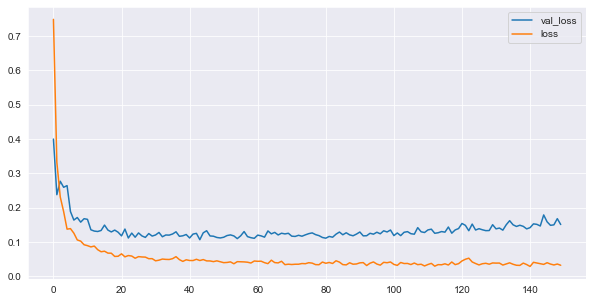

In [2317]:
plt.figure(10, (10, 5))
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])
plt.legend(['val_loss', 'loss'])

We can see overfitting starts at around 50 epochs. This is important for when we want to train the model on the whole dataset. Now let's check performance.

In [2318]:
# load back
model.load_weights('./data/DL/model_weights_best.h5')

# predict
y_preds = model.predict(x_eval, batch_size=10)

30/30 [==============================] - 0s 1ms/step


(291, 1)

In [2319]:
# some trickery to get back to the original scale
preds_dummy = np.zeros((x_eval.shape[0], x_eval.shape[1] + 1))
preds_dummy[:, -1] = np.squeeze(y_preds)

y_eval_dummy = np.zeros((x_eval.shape[0], x_eval.shape[1] + 1))
y_eval_dummy[:, -1] = np.squeeze(y_eval)

preds_rescaled = scaler.inverse_transform(preds_dummy)[:, -1]
y_eval_rescaled = scaler.inverse_transform(y_eval_dummy)[:, -1]

In [2320]:
# evaluate
rmse(y_eval_rescaled, preds_rescaled)

0.1305113416999801

In [2321]:
# final training on all training data
dl = build()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 333)]             0         
                                                                 
 dense_29 (Dense)            (None, 1000)              334000    
                                                                 
 dropout_19 (Dropout)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 100)               100100    
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 434,201
Trainable params: 434,201
Non-traina

In [2322]:
dl.fit(x=np.vstack((x_train, x_eval)),
                 y=np.vstack((y_train.reshape(-1,1), y_eval.reshape(-1,1))),
                 epochs=50,
                 batch_size=32,
                 verbose=0)

In [2324]:
# normalize test data
x_test = scaler.transform(np.hstack((X_test, np.zeros((X_test.shape[0],1)))))[:,:-1]

C:\KBApps\conda\envs\phm2\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [2325]:
# predict on test data
y_preds_test = dl.predict(x_test, batch_size=10)

146/146 [==============================] - 0s 1ms/step


In [2326]:
# scale back
preds_dummy_test = np.zeros((x_test.shape[0], x_test.shape[1] + 1))
preds_dummy_test[:, -1] = np.squeeze(y_preds_test)
preds_rescaled_test = np.expm1(scaler.inverse_transform(preds_dummy_test)[:, -1])
preds_test_dl = preds_rescaled_test

In [2327]:
preds_final_dl = pd.DataFrame.from_dict({"Id": test_IDs, "SalePrice": preds_rescaled_test})
preds_final_dl

,Id,SalePrice
0,1461,129054.986206
1,1462,157320.834576
2,1463,180841.881737
3,1464,198907.945370
4,1465,177793.461473
...,...,...
1454,2915,101726.769627
1455,2916,85484.560305
1456,2917,163675.105216
1457,2918,119596.487623


In [2328]:
# save dl only freestyle preds
preds_final_dl.to_csv("./data/freestyle_preds.csv", index=None)

In [2329]:
# create ensemble preds
preds_test_ensemble = np.mean(np.hstack((preds_test_gb.reshape(-1,1), preds_test_rf.reshape(-1,1), preds_test_dl.reshape(-1,1))), axis=1)

In [2330]:
preds_final_ensemble = pd.DataFrame.from_dict({"Id": test_IDs, "SalePrice": preds_test_ensemble})
preds_final_ensemble

,Id,SalePrice
0,1461,130671.445533
1,1462,164187.247623
2,1463,177533.124158
3,1464,192248.551723
4,1465,188200.025266
...,...,...
1454,2915,91726.542895
1455,2916,85955.460631
1456,2917,165836.415112
1457,2918,114531.118434


In [2331]:
# save dl only freestyle preds -> this got 0.13578 in Kaggle
preds_final_ensemble.to_csv("./data/freestyle_ensemble_preds.csv", index=None)